In [1]:
import boto3
import pandas as pd
import numpy as np
import io
# local libraries
import hodl_functions

pd.options.display.max_rows = 50
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

# Data Validation

In [3]:
dedup_query = """
                SELECT rt.coin_partition
                      , rt.trade_id
                      , rt.price
                      , rt.qty
                      , rt.is_buyer_maker
                      , rt.is_best_match
                      , rt.trade_time
                      , max(rt.file_name) as file_name
                 FROM hodl.recent_trades as rt
                 LEFT JOIN hodl.recent_trades_dedup as rtdd
                     ON rt.coin_partition = rtdd.coin_partition
                     AND rt.trade_id = rtdd.trade_id
                     AND rt.trade_time = rtdd.trade_time
                 GROUP BY rt.coin_partition
                        , rt.trade_id
                        , rt.price
                        , rt.qty
                        , rt.is_buyer_maker
                        , rt.is_best_match
                        , rt.trade_time
                        , rtdd.trade_id
                 HAVING rt.coin_partition = 'bnbbtc'
                     AND rtdd.trade_id IS NULL
              """

missing_trades = """
                   SELECT coin_partition
                        , min(trade_id) as min_trade_id
                        , max(trade_id) as max_trade_id
                        , count(distinct trade_id) as unique_trades
                        , cast(max(trade_id) as integer) - cast(min(trade_id) as integer) as unique_trade_ids
                   FROM hodl.raw_trades_recents
                   GROUP BY coin_partition
                 """

no_dups = """    SELECT coin_partition, count(*)
                 FROM (
                   SELECT coin_partition, trade_id, trade_time
                   FROM hodl.raw_trades_recents
                   GROUP BY coin_partition, trade_id, trade_time
                   HAVING count(*) = 1
                 )
                 GROUP BY coin_partition
                 """

dups_query = """SELECT coin_partition
              , trade_id
              , price
              , qty
              , is_buyer_maker
              , is_best_match
              , trade_time
              , from_unixtime(cast(trade_time as bigint)/1000)
              , max(file_name) as file_name
         FROM hodl.recent_trades
         GROUP BY coin_partition
              , trade_id
              , price
              , qty
              , is_buyer_maker
              , is_best_match
              , trade_time
        HAVING coin_partition = 'bnbbtc'
        """

time_between_trades_sql = """
    select trade_time - prev_time as time_delta
    , coin_partition
    , ttimestamp
    from (
      select cast(trade_time as bigint) as trade_time
      , cast(Lead(trade_time) OVER (ORDER BY trade_time DESC) as bigint) as prev_time
      , coin_partition
      , from_unixtime(cast(trade_time as double)/1000) as ttimestamp
      , cast(trade_time as bigint)/1000/60/60 as minute
      from recent_trades_dedup
      where coin_partition = 'ethusdt'
    )
    order by (trade_time - prev_time) desc
    """

In [294]:
time_between_df = hodl_functions.pandas_read_athena(time_between_trades_sql)
time_between_df

Execution ID: a8b129a7-52b8-4b15-8d48-55b697c40024
Query execution failed: {'QueryExecution': {'QueryExecutionId': 'a8b129a7-52b8-4b15-8d48-55b697c40024', 'Query': "select trade_time - prev_time as time_delta\n    , coin_partition\n    , ttimestamp\n    from (\n      select cast(trade_time as bigint) as trade_time\n      , cast(Lead(trade_time) OVER (ORDER BY trade_time DESC) as bigint) as prev_time\n      , coin_partition\n      , from_unixtime(cast(trade_time as double)/1000) as ttimestamp\n      , cast(trade_time as bigint)/1000/60/60 as minute\n      from recent_trades_dedup\n      where coin_partition = 'ethusdt'\n    )\n    order by (trade_time - prev_time) desc", 'ResultConfiguration': {'OutputLocation': 's3://loidsig-crypto/athena_results/a8b129a7-52b8-4b15-8d48-55b697c40024.csv'}, 'QueryExecutionContext': {'Database': 'hodl'}, 'Status': {'State': 'FAILED', 'StateChangeReason': 'com.facebook.presto.hive.DataCatalogException: Database hodl not found. Please check your query.', '

""


In [5]:
pd.to_datetime(time_between_df['ttimestamp']).describe()

count                        2417312
unique                       1619845
top       2018-04-02 23:27:54.747000
freq                             352
first     2018-03-25 13:16:32.094000
last      2018-04-14 00:25:00.431000
Name: ttimestamp, dtype: object

In [6]:
(time_between_df['time_delta']/1000).describe()

count    2.417311e+06
mean     6.956938e-01
std      1.904647e+00
min      0.000000e+00
25%      0.000000e+00
50%      7.200000e-02
75%      5.690000e-01
max      1.078450e+02
Name: time_delta, dtype: float64

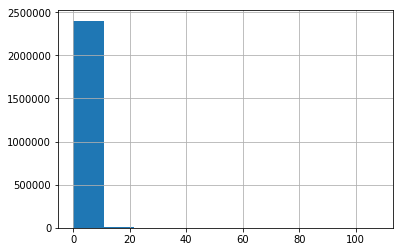

In [7]:
(time_between_df['time_delta']/1000).hist()

In [228]:
processed_dates_df = hodl_functions.pandas_read_athena(f"""SELECT DISTINCT CAST(micro_timestamp as bigint)/1000/60/60/24 as day_id
                                                                  FROM binance.historic_trades
                                                                  WHERE coin_partition = 'ethusdt'
                                                                  ORDER BY CAST(micro_timestamp as bigint)/1000/60/60/24""")

Execution ID: ba9f95b5-7cc8-4055-8e33-4225db2a9f25
